# SVM

In [33]:
import numpy as np
import pandas as pd 
from sklearn.utils import shuffle

In [34]:
data_train = pd.read_csv('mnist_train.csv')
data_test = pd.read_csv('mnist_test.csv')
print(data_train.shape)
print(data_test.shape)

(60000, 785)
(10000, 785)


In [35]:
data_train.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### We normalize the data between(0,1) and separate the label.

In [36]:
X_train = data_train.iloc[:,1:785]
X_train['label'] = 1
Y_train = data_train.iloc[:,0]

X_test = data_test.iloc[:,1:785]
X_test['label'] = 1
Y_test = data_test.iloc[:,0]
data_train

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59997,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### K-Fold Cross Validation

In [5]:
class KFolds:
    def __init__(self, n_splits, shuffle = True, seed = 4321):
        self.seed = seed
        self.shuffle = shuffle
        self.n_splits = n_splits
        
    def split(self, X):
        """pass in the data to create train/test split for k fold"""
        # shuffle modifies indices inplace
        n_samples = X.shape[0]
        indices = np.arange(n_samples)
        if self.shuffle:
            rstate = np.random.RandomState(self.seed)
            rstate.shuffle(indices)

        for test_mask in self._iter_test_masks(n_samples, indices):
            train_index = indices[np.logical_not(test_mask)]
            test_index = indices[test_mask]
            yield train_index, test_index
        
    def _iter_test_masks(self, n_samples, indices):
        """
        create the mask for the test set, then the indices that
        are not in the test set belongs in the training set
        """
        fold_sizes = (n_samples // self.n_splits) * np.ones(self.n_splits, dtype = np.int)
        fold_sizes[:n_samples % self.n_splits] += 1

        current = 0
        for fold_size in fold_sizes:
            start, stop = current, current + fold_size
            test_indices = indices[start:stop]
            test_mask = np.zeros(n_samples, dtype = np.bool)
            test_mask[test_indices] = True
            yield test_mask
            current = stop

#### compute loss function and gradient descent and BGD!

In [12]:
import pandas as pd

def compute_cost(W, X, Y, lamba):
    # calculate hinge loss
    N = X.shape[0]
    distances = 1 - (np.array(Y).reshape(N,1) * np.dot(np.array(X).reshape(N,785), W.reshape(785,1)))
    distances[distances < 0] = 0  # equivalent to max(0, distance)
    hinge_loss = (np.sum(distances) / N)
    
    # calculate cost
    cost = lamba*(W*W).sum() + hinge_loss
    return cost


def calculate_cost_gradient(W, X_batch, Y_batch, lamba):
    N = X_batch.shape[0]
    Y_batch = np.array(Y_batch)
    X_batch = np.array(X_batch)
    distance = 1-(Y_batch.reshape(N,1)*np.dot(X_batch.reshape(N,785), W.reshape(785,1)))
    dw = np.zeros(len(W))
    d = pd.DataFrame(distance)
    d[d > 0] = 1
    d[d <= 0] = 0
    d = np.array(d)
    dw=2*lamba*W-((Y_batch.reshape(N,1)*X_batch.reshape(N,785)*\
                   d.reshape(N,1)).sum(axis=0)).reshape(785,1)
    dw = dw/len(Y_batch)   # average
    return dw


def bgd(features, outputs,lamba):
    max_epochs = 50
    learning_rate = 0.001
    weights = np.random.normal(0, 0.1, size=(features.shape[1],1))
    nth = 0
    prev_cost = float("inf")
    cost_threshold = 0.01  # in percent
    # stochastic gradient descent
    for epoch in range(1, max_epochs):
        # shuffle to prevent repeating update cycles
        X, Y = shuffle(features, outputs)
        ascent = calculate_cost_gradient(weights, X, Y,lamba)
        weights = weights - (learning_rate * ascent)
        
        # convergence check on 2^nth epoch
        if epoch == 2 ** nth or epoch == max_epochs - 1:
            cost = compute_cost(weights, features, outputs,lamba)
            print("Epoch is:{} and Cost is: {}".format(epoch, cost))
            # stoppage criterion
            if abs(prev_cost - cost) < cost_threshold * prev_cost:
                return weights
            prev_cost = cost
            nth += 1
    return weights







#### choosing best lambda by cross_validation

In [13]:
kf = KFolds(n_splits = 6, shuffle = False, seed = 4312)
lamba = [0.0000000001, 0.00000001, 0.000001, 0.0001, 0.01, 1]
cls_cost = []
kfolds_cost = []
lamba_cost = []

for lamba_index in range(6):
    nth = 0
    for train_index, test_index in kf.split(X_train):
        nth = nth+1
        for cls in range(10):
            X , X_val = X_train.iloc[train_index,:], X_train.iloc[test_index,:]
            Y , Y_val = Y_train.iloc[train_index], Y_train.iloc[test_index]

            # train the model
            print(f'training started for class {cls} and {nth}th fold and hyperparameter {lamba_index+1}: ...')
        
            Y[Y == cls]=  1
            Y[Y != cls]= -1
            Y_val[Y_val == cls]= 1
            Y_val[Y_val != cls]= -1
            W = bgd(X.to_numpy(), Y.to_numpy(),lamba[lamba_index])
            print("training finished.") 
            cost = compute_cost(W, X_val.to_numpy(), Y_val.to_numpy(), lamba[lamba_index])
            cls_cost.append(cost)
        
        
         
        kfolds_cost.append(sum(cls_cost)/10)
      
    lamba_cost.append(sum(kfolds_cost)/6)
    

mincost = lamba_cost[0]
bestlambda = lamba[0]    
for i in range(6):
    if(lamba_cost[i] <= mincost):
        mincost=lamba_cost[i]
        bestlambda = lamba[i]

print("best lambda by cross_validation is",bestlambda)    

training started for class 0 and 1th fold and hyperparameter 1: ...
Epoch is:1 and Cost is: 8.463726426061994e-10
Epoch is:2 and Cost is: 8.463726426061994e-10
training finished.
training started for class 1 and 1th fold and hyperparameter 1: ...
Epoch is:1 and Cost is: 109.6646851009832
Epoch is:2 and Cost is: 86.24500188334683
Epoch is:4 and Cost is: 39.636467433125354
Epoch is:8 and Cost is: 6.0152218454041435
Epoch is:16 and Cost is: 3.8248856347795686
Epoch is:32 and Cost is: 2.604117315994559
Epoch is:49 and Cost is: 2.0070445100249614
training finished.
training started for class 2 and 1th fold and hyperparameter 1: ...
Epoch is:1 and Cost is: 8.858306922205356e-10
Epoch is:2 and Cost is: 8.858306922205356e-10
training finished.
training started for class 3 and 1th fold and hyperparameter 1: ...
Epoch is:1 and Cost is: 8.752299477919323e-10
Epoch is:2 and Cost is: 8.752299477919323e-10
training finished.
training started for class 4 and 1th fold and hyperparameter 1: ...
Epoch i

Epoch is:32 and Cost is: 1.6321697168367708
Epoch is:49 and Cost is: 1.4026145346491032
training finished.
training started for class 2 and 4th fold and hyperparameter 1: ...
Epoch is:1 and Cost is: 9.107584385063685e-10
Epoch is:2 and Cost is: 9.107584385063685e-10
training finished.
training started for class 3 and 4th fold and hyperparameter 1: ...
Epoch is:1 and Cost is: 8.917553279382212e-10
Epoch is:2 and Cost is: 8.917553279382212e-10
training finished.
training started for class 4 and 4th fold and hyperparameter 1: ...
Epoch is:1 and Cost is: 8.24006658648867e-10
Epoch is:2 and Cost is: 8.24006658648867e-10
training finished.
training started for class 5 and 4th fold and hyperparameter 1: ...
Epoch is:1 and Cost is: 0.09052369318196589
Epoch is:2 and Cost is: 0.08651424452882876
Epoch is:4 and Cost is: 0.07942627224144679
Epoch is:8 and Cost is: 0.06884397651651195
Epoch is:16 and Cost is: 0.054330087337220195
Epoch is:32 and Cost is: 0.03859007561328148
Epoch is:49 and Cost is

Epoch is:1 and Cost is: 8.471485580740307e-08
Epoch is:2 and Cost is: 8.4714855807403e-08
training finished.
training started for class 5 and 1th fold and hyperparameter 2: ...
Epoch is:1 and Cost is: 8.472838772188038e-08
Epoch is:2 and Cost is: 8.47283877218803e-08
training finished.
training started for class 6 and 1th fold and hyperparameter 2: ...
Epoch is:1 and Cost is: 0.001781980482813918
Epoch is:2 and Cost is: 0.0017780658011791195
training finished.
training started for class 7 and 1th fold and hyperparameter 2: ...
Epoch is:1 and Cost is: 8.734093324738456e-08
Epoch is:2 and Cost is: 8.734093324738449e-08
training finished.
training started for class 8 and 1th fold and hyperparameter 2: ...
Epoch is:1 and Cost is: 8.186486613735154e-08
Epoch is:2 and Cost is: 8.186486613735146e-08
training finished.
training started for class 9 and 1th fold and hyperparameter 2: ...
Epoch is:1 and Cost is: 9.160246097145914e-08
Epoch is:2 and Cost is: 9.160246097145906e-08
training finished

Epoch is:4 and Cost is: 61.146073507014
Epoch is:8 and Cost is: 3.2214301546266393
Epoch is:16 and Cost is: 2.4883744682494187
Epoch is:32 and Cost is: 2.065070308043065
Epoch is:49 and Cost is: 1.8077908641602807
training finished.
training started for class 2 and 5th fold and hyperparameter 2: ...
Epoch is:1 and Cost is: 0.016927855469592846
Epoch is:2 and Cost is: 0.016779604447262165
training finished.
training started for class 3 and 5th fold and hyperparameter 2: ...
Epoch is:1 and Cost is: 7.826039279813354e-08
Epoch is:2 and Cost is: 7.826039279813348e-08
training finished.
training started for class 4 and 5th fold and hyperparameter 2: ...
Epoch is:1 and Cost is: 0.6932991429160306
Epoch is:2 and Cost is: 0.5088341001692132
Epoch is:4 and Cost is: 0.34404905625650967
Epoch is:8 and Cost is: 0.20756515800294575
Epoch is:16 and Cost is: 0.11516495112895765
Epoch is:32 and Cost is: 0.05304985649320235
Epoch is:49 and Cost is: 0.033585632333042494
training finished.
training start

training started for class 7 and 2th fold and hyperparameter 3: ...
Epoch is:1 and Cost is: 9.510901363155578e-06
Epoch is:2 and Cost is: 9.510901363154819e-06
training finished.
training started for class 8 and 2th fold and hyperparameter 3: ...
Epoch is:1 and Cost is: 8.727921584814785e-06
Epoch is:2 and Cost is: 8.727921584814087e-06
training finished.
training started for class 9 and 2th fold and hyperparameter 3: ...
Epoch is:1 and Cost is: 8.205540757227052e-06
Epoch is:2 and Cost is: 8.205540757226397e-06
training finished.
training started for class 0 and 3th fold and hyperparameter 3: ...
Epoch is:1 and Cost is: 9.874153528743239e-06
Epoch is:2 and Cost is: 9.874153528742447e-06
training finished.
training started for class 1 and 3th fold and hyperparameter 3: ...
Epoch is:1 and Cost is: 97.1336491096397
Epoch is:2 and Cost is: 73.55642218660817
Epoch is:4 and Cost is: 26.50772243066454
Epoch is:8 and Cost is: 2.9730661329286336
Epoch is:16 and Cost is: 2.5558598728256237
Epoc

Epoch is:2 and Cost is: 0.011016597213301536
Epoch is:4 and Cost is: 0.010789640892521145
Epoch is:8 and Cost is: 0.010337375475972086
Epoch is:16 and Cost is: 0.00954235820474284
Epoch is:32 and Cost is: 0.008123323576990527
Epoch is:49 and Cost is: 0.006624645910190099
training finished.
training started for class 0 and 6th fold and hyperparameter 3: ...
Epoch is:1 and Cost is: 7.964846195011851e-06
Epoch is:2 and Cost is: 7.964846195011214e-06
training finished.
training started for class 1 and 6th fold and hyperparameter 3: ...
Epoch is:1 and Cost is: 55.92020958239321
Epoch is:2 and Cost is: 31.658251495063027
Epoch is:4 and Cost is: 5.172110136710738
Epoch is:8 and Cost is: 3.7433336336979535
Epoch is:16 and Cost is: 2.6506157918584727
Epoch is:32 and Cost is: 1.9579884804051912
Epoch is:49 and Cost is: 1.6684852793860272
training finished.
training started for class 2 and 6th fold and hyperparameter 3: ...
Epoch is:1 and Cost is: 7.711810802309228e-06
Epoch is:2 and Cost is: 7.7

Epoch is:1 and Cost is: 0.06736663285032891
Epoch is:2 and Cost is: 0.06538977650883178
Epoch is:4 and Cost is: 0.0618372417989545
Epoch is:8 and Cost is: 0.05592029408352191
Epoch is:16 and Cost is: 0.04684862739798569
Epoch is:32 and Cost is: 0.0344625220023191
Epoch is:49 and Cost is: 0.02652887708683134
training finished.
training started for class 9 and 2th fold and hyperparameter 4: ...
Epoch is:1 and Cost is: 0.0007428813730654309
Epoch is:2 and Cost is: 0.000742881373059488
training finished.
training started for class 0 and 3th fold and hyperparameter 4: ...
Epoch is:1 and Cost is: 0.0009256407404345617
Epoch is:2 and Cost is: 0.0009256407404271566
training finished.
training started for class 1 and 3th fold and hyperparameter 4: ...
Epoch is:1 and Cost is: 94.65914227936503
Epoch is:2 and Cost is: 71.0818989748847
Epoch is:4 and Cost is: 23.99078305991705
Epoch is:8 and Cost is: 2.441769242513483
Epoch is:16 and Cost is: 2.1697321546833654
Epoch is:32 and Cost is: 1.866228131

training started for class 5 and 6th fold and hyperparameter 4: ...
Epoch is:1 and Cost is: 0.004426809146798737
Epoch is:2 and Cost is: 0.004421230090971804
training finished.
training started for class 6 and 6th fold and hyperparameter 4: ...
Epoch is:1 and Cost is: 0.0008331207163234822
Epoch is:2 and Cost is: 0.0008331207163168174
training finished.
training started for class 7 and 6th fold and hyperparameter 4: ...
Epoch is:1 and Cost is: 0.0007964191807477173
Epoch is:2 and Cost is: 0.0007964191807413461
training finished.
training started for class 8 and 6th fold and hyperparameter 4: ...
Epoch is:1 and Cost is: 0.001242116733919585
Epoch is:2 and Cost is: 0.0012402965309516551
training finished.
training started for class 9 and 6th fold and hyperparameter 4: ...
Epoch is:1 and Cost is: 0.48170844170918775
Epoch is:2 and Cost is: 0.4096201912302123
Epoch is:4 and Cost is: 0.3150260816987752
Epoch is:8 and Cost is: 0.20447130456326645
Epoch is:16 and Cost is: 0.11892210038957818


Epoch is:8 and Cost is: 2.8703620611296223
Epoch is:16 and Cost is: 2.2412903545617495
Epoch is:32 and Cost is: 1.7718412095672886
Epoch is:49 and Cost is: 1.5327464332351959
training finished.
training started for class 2 and 4th fold and hyperparameter 5: ...
Epoch is:1 and Cost is: 0.08599847275223158
Epoch is:2 and Cost is: 0.0859964451804654
training finished.
training started for class 3 and 4th fold and hyperparameter 5: ...
Epoch is:1 and Cost is: 0.08566191757515065
Epoch is:2 and Cost is: 0.08566191750662114
training finished.
training started for class 4 and 4th fold and hyperparameter 5: ...
Epoch is:1 and Cost is: 0.0857242219124187
Epoch is:2 and Cost is: 0.08572422184383933
training finished.
training started for class 5 and 4th fold and hyperparameter 5: ...
Epoch is:1 and Cost is: 0.08224005355360772
Epoch is:2 and Cost is: 0.08224005348781567
training finished.
training started for class 6 and 4th fold and hyperparameter 5: ...
Epoch is:1 and Cost is: 0.08617108039553

Epoch is:1 and Cost is: 8.847702346625434
Epoch is:2 and Cost is: 8.59520778983388
Epoch is:4 and Cost is: 8.403561493202204
Epoch is:8 and Cost is: 8.282458613826222
Epoch is:16 and Cost is: 8.220161607125302
training finished.
training started for class 0 and 2th fold and hyperparameter 6: ...
Epoch is:1 and Cost is: 7.960085720839958
Epoch is:2 and Cost is: 7.960085084033113
training finished.
training started for class 1 and 2th fold and hyperparameter 6: ...
Epoch is:1 and Cost is: 76.17334365377658
Epoch is:2 and Cost is: 52.79790197601156
Epoch is:4 and Cost is: 12.617388188395116
Epoch is:8 and Cost is: 10.10562518244453
Epoch is:16 and Cost is: 9.474161407787198
Epoch is:32 and Cost is: 9.009471542862187
Epoch is:49 and Cost is: 8.757832597568852
training finished.
training started for class 2 and 2th fold and hyperparameter 6: ...
Epoch is:1 and Cost is: 8.051121953897189
Epoch is:2 and Cost is: 8.030131250744311
training finished.
training started for class 3 and 2th fold an

training started for class 9 and 5th fold and hyperparameter 6: ...
Epoch is:1 and Cost is: 9.612459718602933
Epoch is:2 and Cost is: 9.612458949606172
training finished.
training started for class 0 and 6th fold and hyperparameter 6: ...
Epoch is:1 and Cost is: 9.418949542288082
Epoch is:2 and Cost is: 9.418948788772134
training finished.
training started for class 1 and 6th fold and hyperparameter 6: ...
Epoch is:1 and Cost is: 129.3229547292508
Epoch is:2 and Cost is: 104.8207363708355
Epoch is:4 and Cost is: 55.96201239243368
Epoch is:8 and Cost is: 11.788813265970475
Epoch is:16 and Cost is: 10.59179026300556
Epoch is:32 and Cost is: 9.986386603975964
Epoch is:49 and Cost is: 9.596221213752036
training finished.
training started for class 2 and 6th fold and hyperparameter 6: ...
Epoch is:1 and Cost is: 8.234600438490158
Epoch is:2 and Cost is: 8.234599779722135
training finished.
training started for class 3 and 6th fold and hyperparameter 6: ...
Epoch is:1 and Cost is: 7.96003446

In [14]:
print("cost values for different lambda!")
print("best lambda is:",bestlambda)
lamba_cost

cost values for different lambda!
best lambda is: 1e-10


[0.7193620250376043,
 2.4589621157382484,
 5.284213132708664,
 9.288772790068487,
 14.71488085613028,
 50.647685507344]

### Batch Gradient Descent  

In [39]:
import pandas as pd

def compute_cost2(W, X, Y, lamba):
    # calculate hinge loss
    N = X.shape[0]
    distances = 1 - (np.array(Y).reshape(N,1) * np.dot(np.array(X).reshape(N,785), W.reshape(785,1)))
    distances[distances < 0] = 0  # equivalent to max(0, distance)
    hinge_loss = (np.sum(distances) / N)
    
    # calculate cost
    cost = lamba*(W*W).sum() + hinge_loss
    return cost


def calculate_cost_gradient2(W, X_batch, Y_batch, lamba):
    N = X_batch.shape[0]
    Y_batch = np.array(Y_batch)
    X_batch = np.array(X_batch)
    distance = 1-(Y_batch.reshape(N,1)*np.dot(X_batch.reshape(N,785), W.reshape(785,1)))
    dw = np.zeros(len(W))
    d = pd.DataFrame(distance)
    d[d > 0] = 1
    d[d <= 0] = 0
    d = np.array(d)
    dw=2*lamba*W-((Y_batch.reshape(N,1)*X_batch.reshape(N,785)*\
                   d.reshape(N,1)).sum(axis=0)).reshape(785,1)
    dw = dw/len(Y_batch)   # average
    return dw


def bgd2(features, outputs,lamba, X_t, Y_t):
    train_cost = []
    test_cost = []
    max_epochs = 100
    learning_rate = 0.01
    weights = np.random.normal(0, 0.1, size=(features.shape[1],1))
    nth = 0
    prev_cost = float("inf")
    cost_threshold = 0.01  # in percent
    # stochastic gradient descent
    for epoch in range(1, max_epochs):
        # shuffle to prevent repeating update cycles
        X, Y = shuffle(features, outputs)
        ascent = calculate_cost_gradient2(weights, X, Y,lamba)
        weights = weights - (learning_rate * ascent)
        
        cost = compute_cost2(weights, features, outputs,lamba)
        train_cost.append(cost)
        cost = compute_cost2(weights, X_t, Y_t,lamba)
        test_cost.append(cost)

        # convergence check on 2^nth epoch
        if epoch == 2 ** nth or epoch == max_epochs - 1:
            cost = compute_cost2(weights, features, outputs,lamba)
            print("Epoch is:{} and Cost is: {} for Train data!".format(epoch, cost))
            cost = compute_cost2(weights, X_t, Y_t,lamba)
            print("Epoch is:{} and Cost is: {} for Test data!".format(epoch, cost))
            # stoppage criterion
            if abs(prev_cost - cost) < cost_threshold * prev_cost:
                return weights, train_cost, test_cost 
            prev_cost = cost
            nth += 1
    return weights, train_cost, test_cost 


In [48]:
cls_test_cost = []
cls_train_cost = []
cls_weights = []
cls_Y_predict = []
X_train = data_train.iloc[:,1:785]/255
X_train['label'] = 1
Y_train = data_train.iloc[:,0]

X_test = data_test.iloc[:,1:785]/255
X_test['label'] = 1
Y_test = data_test.iloc[:,0]

bestlambda = 0.0000000001
for cls in range(10):
    # train the model
    print(f'training started for class {cls}: ...')
    X , Y = X_train.copy() , Y_train.copy() 
    X_t , Y_t = X_test.copy() , Y_test.copy() 
    Y[Y == cls]=  1
    Y[Y != cls]= -1
    Y_t[Y_t == cls]= 1
    Y_t[Y_t != cls]= -1
    W, Tr_cost, Te_cost = bgd2(X.to_numpy(), Y.to_numpy(), bestlambda, X_t, Y_t)
    cls_test_cost.append(np.array(Te_cost))
    cls_train_cost.append(Tr_cost)
    cls_weights.append(W)
    print("training finished.") 
        
    # testing the model on test set
    N = X_t.shape[0]
    y_test_predicted = np.array([])
    y_test_predicted = (np.dot(np.array(X_t).reshape(N,785), np.array(W).reshape(785,1))) #model
    cls_Y_predict.append(np.array(y_test_predicted).reshape(1,10000))
    


N = Y_test.shape[0]    
Data = np.array(pd.DataFrame(np.array(cls_Y_predict).reshape(10,10000)).idxmax(axis = 0)).reshape(N,1)
weights = np.array(pd.DataFrame(np.array(cls_weights).reshape(10,785)).max(axis=0)/10).reshape(785,1)
Y_test = np.array(Y_test).reshape(N,1)
mark = np.ones([N,1])
cnt = 0

for i in range(N):
    if(Y_test[i] == Data[i]):
        cnt += 1
        mark[i] = 1
    elif(Y_test[i] != Data[i]):
        mark[i] = -1
    
distances = pd.DataFrame(1 - mark)
distances[distances < 0] = 0  # equivalent to max(0, distance)
hinge_loss = (np.sum(distances) / N)
    
# calculate cost
cost = bestlambda*(weights*weights).sum() + hinge_loss    
print(f'cost for final model is {cost}!')
print(f'accuracy for final model is {cnt/N*100}! ')
            
        



training started for class 0: ...
Epoch is:1 and Cost is: 0.2098755101362932 for Train data!
Epoch is:1 and Cost is: 0.2088195123363316 for Test data!
Epoch is:2 and Cost is: 0.15674006185545006 for Train data!
Epoch is:2 and Cost is: 0.1555308650060843 for Test data!
Epoch is:4 and Cost is: 0.09931310670639548 for Train data!
Epoch is:4 and Cost is: 0.09791131104887987 for Test data!
Epoch is:8 and Cost is: 0.05427133287105529 for Train data!
Epoch is:8 and Cost is: 0.05289410506808532 for Test data!
Epoch is:16 and Cost is: 0.026911678061016353 for Train data!
Epoch is:16 and Cost is: 0.025823340776279086 for Test data!
Epoch is:32 and Cost is: 0.012927216789726663 for Train data!
Epoch is:32 and Cost is: 0.011987707867280784 for Test data!
Epoch is:64 and Cost is: 0.006323413185807778 for Train data!
Epoch is:64 and Cost is: 0.005478192074745616 for Test data!
Epoch is:99 and Cost is: 0.00401555048426854 for Train data!
Epoch is:99 and Cost is: 0.003255551725090112 for Test data!
tr

Epoch is:2 and Cost is: 1.435026793918808 for Train data!
Epoch is:2 and Cost is: 1.4398077629643942 for Test data!
Epoch is:4 and Cost is: 0.7648646397216966 for Train data!
Epoch is:4 and Cost is: 0.7577807304775152 for Test data!
Epoch is:8 and Cost is: 0.1794093912022394 for Train data!
Epoch is:8 and Cost is: 0.17090962489489722 for Test data!
Epoch is:16 and Cost is: 0.04679026602957145 for Train data!
Epoch is:16 and Cost is: 0.04322829630381197 for Test data!
Epoch is:32 and Cost is: 0.015203040004954847 for Train data!
Epoch is:32 and Cost is: 0.01402425459842376 for Test data!
Epoch is:64 and Cost is: 0.005757818295650899 for Train data!
Epoch is:64 and Cost is: 0.0054196346997948276 for Test data!
Epoch is:99 and Cost is: 0.003391576395302975 for Train data!
Epoch is:99 and Cost is: 0.003201553768375743 for Test data!
training finished.
training started for class 9: ...
Epoch is:1 and Cost is: 0.5818351936922708 for Train data!
Epoch is:1 and Cost is: 0.5813970429592147 for 

Text(0.5, 0, 'epoch')

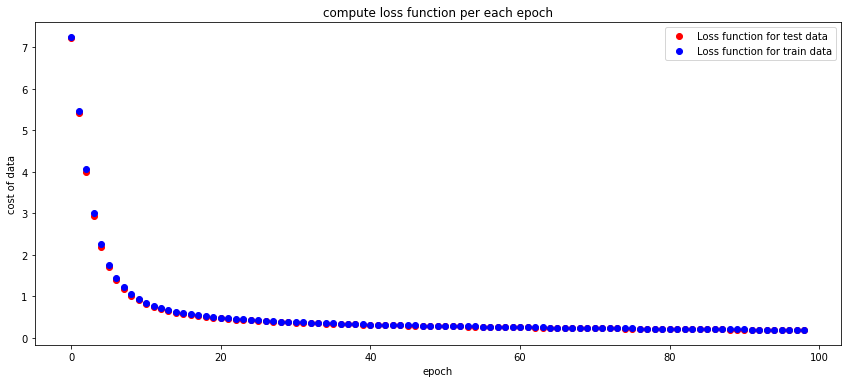

In [49]:
import matplotlib.pyplot as plt


test_cost = np.array(cls_test_cost).reshape(10,99).sum(axis=0)
train_cost = np.array(cls_train_cost).reshape(10,99).sum(axis=0)
epoch = np.arange(0, 99, 1)

######### Plotting
axis_color = 'lightgoldenrodyellow'

fig = plt.figure("Leaky Integrate-and-Fire Neuron", figsize=(14, 8))
plt.subplot(111)


plt.title("compute loss function per each epoch")
fig.subplots_adjust(left=0.1, bottom=0.32)

# plot lines
plt.plot(epoch,test_cost,'ro',label="Loss function for test data")[0]
plt.plot(epoch, train_cost,'bo',label="Loss function for train data")[0]
plt.legend(loc="upper right")

# add axis labels
plt.ylabel("cost of data")
plt.xlabel("epoch")


### Stochastic Gradient Descent

In [43]:
import pandas as pd

def compute_costs(W, X, Y, lamba):
    # calculate hinge loss
    N = X.shape[0]
    distances = 1 - (np.array(Y).reshape(N,1) * np.dot(np.array(X).reshape(N,785), W.reshape(785,1)))
    distances[distances < 0] = 0  # equivalent to max(0, distance)
    hinge_loss = (np.sum(distances) / N)
    
    # calculate cost
    cost = lamba*(W*W).sum() + hinge_loss
    return cost


def calculate_cost_gradients(W, X_batch, Y_batch, lamba):
    N = X_batch.shape[0]
    Y_batch = np.array(Y_batch)
    X_batch = np.array(X_batch)
    distance = 1-(Y_batch.reshape(N,1)*np.dot(X_batch.reshape(N,785), W.reshape(785,1)))
    dw = np.zeros(len(W))
    d = pd.DataFrame(distance)
    d[d > 0] = 1
    d[d <= 0] = 0
    d = np.array(d)
    dw=2*lamba*W-((Y_batch.reshape(N,1)*X_batch.reshape(N,785)*\
                   d.reshape(N,1)).sum(axis=0)).reshape(785,1)
    dw = dw   
    return dw


def sgd(features, outputs,lamba, X_t, Y_t):
    train_cost = []
    test_cost = []
    max_epochs = 100
    learning_rate = 0.000001
    weights = np.random.normal(0, 0.1, size=(features.shape[1],1))
    nth = 0
    prev_cost = float("inf")
    cost_threshold = 0.01  # in percent
    # stochastic gradient descent
    for epoch in range(1, max_epochs):
        # shuffle to prevent repeating update cycles
        X, Y = shuffle(features, outputs)
        ascent = calculate_cost_gradients(weights, X, Y,lamba)
        weights = weights - (learning_rate * ascent)
        
        cost = compute_costs(weights, features, outputs,lamba)
        train_cost.append(cost)
        cost = compute_costs(weights, X_t, Y_t,lamba)
        test_cost.append(cost)

        # convergence check on 2^nth epoch
        if epoch == 2 ** nth or epoch == max_epochs - 1:
            cost = compute_costs(weights, features, outputs,lamba)
            print("Epoch is:{} and Cost is: {} for Train data!".format(epoch, cost))
            cost = compute_costs(weights, X_t, Y_t,lamba)
            print("Epoch is:{} and Cost is: {} for Test data!".format(epoch, cost))
            # stoppage criterion
            if abs(prev_cost - cost) < cost_threshold * prev_cost:
                return weights, train_cost, test_cost 
            prev_cost = cost
            nth += 1
    return weights, train_cost, test_cost 


In [44]:
cls_test_cost = []
cls_train_cost = []
cls_weights = []
cls_Y_predict = []
X_train = data_train.iloc[:,1:785]/255
X_train['label'] = 1
Y_train = data_train.iloc[:,0]

X_test = data_test.iloc[:,1:785]/255
X_test['label'] = 1
Y_test = data_test.iloc[:,0]

bestlambda = 0.0000000001
for cls in range(10):
    # train the model
    print(f'training started for class {cls}: ...')
    X , Y = X_train.copy() , Y_train.copy() 
    X_t , Y_t = X_test.copy() , Y_test.copy() 
    Y[Y == cls]=  1
    Y[Y != cls]= -1
    Y_t[Y_t == cls]= 1
    Y_t[Y_t != cls]= -1
    W, Tr_cost, Te_cost = sgd(X.to_numpy(), Y.to_numpy(), bestlambda, X_t, Y_t)
    cls_test_cost.append(np.array(Te_cost))
    cls_train_cost.append(Tr_cost)
    cls_weights.append(W)
    print("training finished.") 
        
    # testing the model on test set
    N = X_t.shape[0]
    y_test_predicted = np.array([])
    y_test_predicted = (np.dot(np.array(X_t).reshape(N,785), np.array(W).reshape(785,1))) #model
    cls_Y_predict.append(np.array(y_test_predicted).reshape(1,10000))
    


N = Y_test.shape[0]    
Data = np.array(pd.DataFrame(np.array(cls_Y_predict).reshape(10,10000)).idxmax(axis = 0)).reshape(N,1)
weights = np.array(pd.DataFrame(np.array(cls_weights).reshape(10,785)).max(axis=0)/10).reshape(785,1)
Y_test = np.array(Y_test).reshape(N,1)
mark = np.ones([N,1])
cnt = 0

for i in range(N):
    if(Y_test[i] == Data[i]):
        cnt += 1
        mark[i] = 1
    elif(Y_test[i] != Data[i]):
        mark[i] = -1
    
distances = pd.DataFrame(1 - mark)
distances[distances < 0] = 0  # equivalent to max(0, distance)
hinge_loss = (np.sum(distances) / N)
    
# calculate cost
cost = bestlambda*(weights*weights).sum() + hinge_loss    
print(f'cost for final model is {cost}!')
print(f'accuracy for final model is {cnt/N*100}! ')

training started for class 0: ...
Epoch is:1 and Cost is: 0.044174557592047116 for Train data!
Epoch is:1 and Cost is: 0.03801157625188664 for Test data!
Epoch is:2 and Cost is: 0.02575579613920057 for Train data!
Epoch is:2 and Cost is: 0.02160750011491256 for Test data!
Epoch is:4 and Cost is: 0.014009722975073762 for Train data!
Epoch is:4 and Cost is: 0.011653179908957484 for Test data!
Epoch is:8 and Cost is: 0.007261547918117412 for Train data!
Epoch is:8 and Cost is: 0.006011891504169207 for Test data!
Epoch is:16 and Cost is: 0.003749402705162302 for Train data!
Epoch is:16 and Cost is: 0.003081203094164011 for Test data!
Epoch is:32 and Cost is: 0.0019200220267287568 for Train data!
Epoch is:32 and Cost is: 0.0016271115611961753 for Test data!
Epoch is:64 and Cost is: 0.0009625920831131252 for Train data!
Epoch is:64 and Cost is: 0.0007955099555755527 for Test data!
Epoch is:99 and Cost is: 0.0006317744817701821 for Train data!
Epoch is:99 and Cost is: 0.0004959333944126476 fo

Epoch is:1 and Cost is: 0.014995755803910382 for Train data!
Epoch is:1 and Cost is: 0.012433066466182743 for Test data!
Epoch is:2 and Cost is: 0.011993144512678355 for Train data!
Epoch is:2 and Cost is: 0.009985839627725125 for Test data!
Epoch is:4 and Cost is: 0.008590814350271987 for Train data!
Epoch is:4 and Cost is: 0.007211289796830785 for Test data!
Epoch is:8 and Cost is: 0.005461441313787404 for Train data!
Epoch is:8 and Cost is: 0.00465091099888332 for Test data!
Epoch is:16 and Cost is: 0.003130276623872345 for Train data!
Epoch is:16 and Cost is: 0.002722191132902543 for Test data!
Epoch is:32 and Cost is: 0.0017315511649586303 for Train data!
Epoch is:32 and Cost is: 0.0014912027101262504 for Test data!
Epoch is:64 and Cost is: 0.0008721833537018781 for Train data!
Epoch is:64 and Cost is: 0.000696549981113345 for Test data!
Epoch is:99 and Cost is: 0.0005328794523348163 for Train data!
Epoch is:99 and Cost is: 0.0004608354673006289 for Test data!
training finished.
t

Text(0.5, 0, 'epoch')

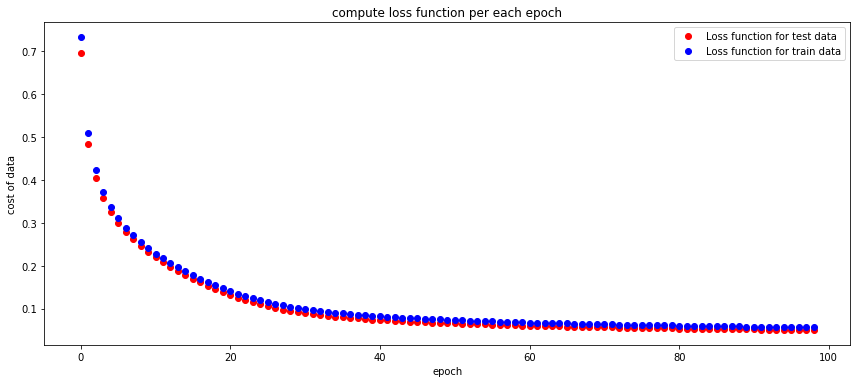

In [47]:
import matplotlib.pyplot as plt


test_cost = np.array(cls_test_cost).reshape(10,99).sum(axis=0)
train_cost = np.array(cls_train_cost).reshape(10,99).sum(axis=0)
epoch = np.arange(0, 99, 1)

######### Plotting
axis_color = 'lightgoldenrodyellow'

fig = plt.figure("compute loss function per each epoch", figsize=(14, 8))
plt.subplot(111)


plt.title("compute loss function per each epoch")
fig.subplots_adjust(left=0.1, bottom=0.32)

# plot lines
plt.plot(epoch,test_cost,'ro',label="Loss function for test data")[0]
plt.plot(epoch, train_cost,'bo',label="Loss function for train data")[0]
plt.legend(loc="upper right")

# add axis labels
plt.ylabel("cost of data")
plt.xlabel("epoch")


sharare zolghadr(610395109)